# Experiment 1

We compare different distance metrics using the following strategy: for each buggy solution for each assignment in our dataset, we create a pool of potential repair candidates using automatic repair tools, and we include our expert annotation in that pool. Following previous work~\cite{gupta_neural_attr}, we include all correct programs submitted by all students for a particular assignment across all academic years into the pool. We highlight that this pool might include the buggy solution's author's own written working solution to the exercise (which may or may not be similar to the buggy solution). Then, using the selected distance metric, we compute the distance between the buggy solution and each candidate repair before ranking each candidate solution from worst to best according to how small the distance value is. Finally, we use the position of the expert annotation in the ranking as an error measure, the Ranking Error (RE). For example, the expert solution being ranked first/having the smallest distance has an RE of 0. To account for the different number of candidate repairs per assignment, we normalize the error by the total number of candidates. We refer to this performance measure as the Normalized Ranking Error (NRE) for the single buggy solution. Finally, we report the Average Normalized Ranking Error (ANRE) for each assignment.

In [1]:
import sys
import ast
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import disable_caching, load_dataset

In [2]:
disable_caching()
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")

In [3]:
from src.common import dist_funcs, new_assignments_id

## Loading the data

#### The full dataset

In [4]:
dataset = load_dataset("koutch/intro_prog", "dublin_data")
ori_df = pd.concat([dataset["train"].to_pandas(), dataset["test"].to_pandas()])
ori_df = ori_df.replace(new_assignments_id)
ori_df

  0%|          | 0/2 [00:00<?, ?it/s]

,submission_id,func_code,assignment_id,func_name,description,test,correct,user,academic_year
0,31156,def square_area(side):\n sq = side * side\n...,square_area,square_area,Return the area of a square.,assert square_area(0)==0 and square_area(21138...,True,80965c2d-45d9-440d-b3c3-403c112145e9,2015
1,6431,def square_area(side):\n sq = side * side\n...,square_area,square_area,Return the area of a square.,assert square_area(0)==0 and square_area(21138...,True,b9e7e608-6036-4d44-8770-a7036176b53c,2015
2,2595,def square_area(side):\n sq = side * side\n...,square_area,square_area,Return the area of a square.,assert square_area(0)==0 and square_area(21138...,True,80965c2d-45d9-440d-b3c3-403c112145e9,2015
3,25266,def square_area(side):\n sq = side * side\n...,square_area,square_area,Return the area of a square.,assert square_area(0)==0 and square_area(21138...,True,80965c2d-45d9-440d-b3c3-403c112145e9,2015
4,28514,def square_perimeter(side):\n par = side * ...,square_perimeter,square_perimeter,Returns the perimeter of a square.,assert square_perimeter(0)==0 and square_perim...,True,80965c2d-45d9-440d-b3c3-403c112145e9,2015
...,...,...,...,...,...,...,...,...,...
14254,11142,def selection_sort(a):\n i = 0\n while i...,selection_sort,selection_sort,Sort a list by repeatedly move minimimum of re...,assert selection_sort([])==[] and selection_so...,False,85db1d22-a87d-4132-bd9a-e07bf9282015,2017
14255,15827,def selection_sort(a):\n i = 0\n while i...,selection_sort,selection_sort,Sort a list by repeatedly move minimimum of re...,assert selection_sort([])==[] and selection_so...,True,85db1d22-a87d-4132-bd9a-e07bf9282015,2017
14256,9653,def selection_sort(a):\n i = 0\n while i...,selection_sort,selection_sort,Sort a list by repeatedly move minimimum of re...,assert selection_sort([])==[] and selection_so...,True,85db1d22-a87d-4132-bd9a-e07bf9282015,2017
14257,38099,"def bsearch(a, q):\n low = 0\n high = le...",bsearch,bsearch,Search for element q in the sorted array a.,"assert bsearch([],12)==0 and bsearch([1, 2, 3,...",False,85db1d22-a87d-4132-bd9a-e07bf9282015,2017


#### The part we annotated 

In [5]:
from datasets import concatenate_datasets, load_dataset

dataset = load_dataset("koutch/intro_prog", "dublin_repair")
                       #download_mode="force_redownload",
                       #ignore_verifications=True)
dataset = concatenate_datasets(list(dataset.values()))
dataframe = dataset.to_pandas()
dataframe = dataframe[dataframe.annotation.astype(bool)]
dataframe = dataframe[dataframe.func_code.astype(bool)]
dataframe = dataframe.replace(new_assignments_id)
dataframe

  0%|          | 0/2 [00:00<?, ?it/s]

,submission_id,func_code,assignment_id,func_name,description,test,annotation,user,academic_year
2,30688,def reverse(a):\n i = 0\n tmp = ''\n ...,reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,def reverse(a):\n i = 0\n tmp = ''\n ...,29883390-7aa0-4484-9f1e-6fd0c1c8c420,2015
3,40460,def reverse(a):\n return a.reverse(),reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,def reverse(a):\n a.reverse()\n return a\n,2157ade0-6890-435b-8669-a884e3233bc7,2015
5,26006,def reverse(a):\n i = 0\n while i < len(...,reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,def reverse(a):\n i = 0\n while i < len(...,df8dd1dd-a7c8-46c0-b89f-ec170a81f08a,2016
6,24752,"def swap(a, i, j):\n tmp = a[i]\n a[i] =...",reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,"def swap(a, i, j):\n tmp = a[i]\n a[i] =...",e8eb24cb-1a57-439b-8705-aed3cec25793,2016
7,27057,def reverse(a):\n i = 0\n while i < len(...,reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,def reverse(a):\n i = 0\n while i < len(...,3bcffc16-908f-42c5-9ac3-f685ae6eca33,2016
...,...,...,...,...,...,...,...,...,...
1998,31463,def minimum(l):\n l = l.sort()\n return ...,minimum,minimum,Return the minimum element in a list of numbers.,"assert minimum([0])==0 and minimum([2, 10, 23,...",def minimum(l):\n l.sort()\n return l[0]\n,3f0a2ff2-f068-43e9-9a21-42850d31b8d3,2017
1999,22521,def minimum(l):\n sorted(l)\n return l,minimum,minimum,Return the minimum element in a list of numbers.,"assert minimum([0])==0 and minimum([2, 10, 23,...",def minimum(l):\n l = sorted(l)\n return...,3f0a2ff2-f068-43e9-9a21-42850d31b8d3,2017
2002,13228,def minimum(l):\n if not l:\n return...,minimum,minimum,Return the minimum element in a list of numbers.,"assert minimum([0])==0 and minimum([2, 10, 23,...",def minimum(l):\n if not l:\n return...,5aa80855-56ed-43aa-9b33-19faef108ec0,2017
2003,23237,def minimum(l):\n if not l:\n return...,minimum,minimum,Return the minimum element in a list of numbers.,"assert minimum([0])==0 and minimum([2, 10, 23,...",def minimum(l):\n if not l:\n return...,5aa80855-56ed-43aa-9b33-19faef108ec0,2017


We need to add back the user_ids to the repair_dataframe 

In [6]:
sub_to_user = ori_df[["submission_id", "user"]].set_index("submission_id")["user"].to_dict()
dataframe["user"] = [sub_to_user[uid] for uid in dataframe["submission_id"]]

## Analysis 

#### Let's look at some distributions

/tmp/ipykernel_29970/1221827687.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=dataframe, x=dist_f.__name__, hue="func_name", kind="kde")


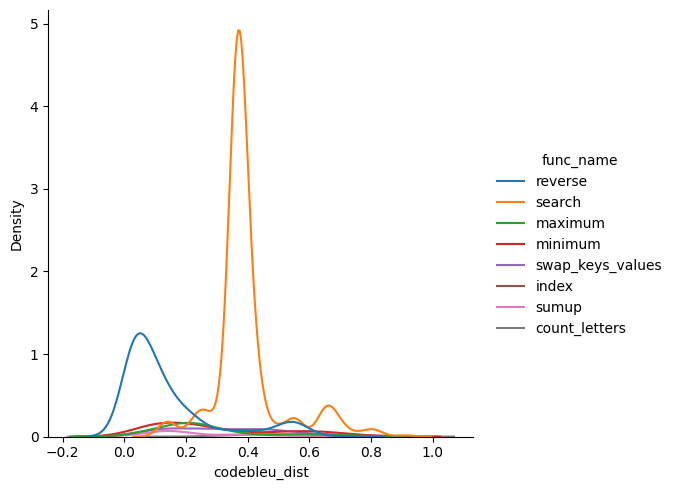

In [7]:
pairs = dataframe[["func_code", "annotation"]].to_numpy()

for dist_f in dist_funcs:
    dataframe[dist_f.__name__] = [dist_f(b, c) for b, c in pairs]
    sns.displot(data=dataframe, x=dist_f.__name__, hue="func_name", kind="kde")

#### Ranking the expert annotaiton

In [8]:
def expert_relative_position(dataframe, ori_df, dist_f, norm=True):
    """ Obtain the relative position of the expert annotation
    according to the given distance metric. """
    
    ranks = []
    columns = ["func_code", "annotation", "assignment_id"]
    for bc, annot, aid in dataframe[columns].to_numpy():
        # Take all the correct solutions submitted to this assignment 
        correct_solutions = ori_df[(ori_df.assignment_id == aid) 
                                   & (ori_df.correct)].func_code.unique()
        correct_solutions = correct_solutions.tolist()
        # Add the expert annotation 
        correct_solutions = [annot] + correct_solutions
        
        # Compute the distance to each potential candidate and
        # rank the candidates based on how close they are to the
        # buggy code according to the distance metric    
        distances = [dist_f(bc, c) for c in correct_solutions]
        sorted_indices = np.argsort(distances)
        # we return the absolute position of the expert annotation
        # we look for the position of the added annotation (last position)
        rank = list(sorted_indices).index(0)
        rank = rank / len(sorted_indices) if norm else rank 
        ranks.append(rank)
        
    return ranks

#### Ranking the student own correct submission

We also take a look at the same thing, but using the student own submitted correct solution later. In that way, we are kind of looking at whether student own submitted solutions align with the expert annotations.

In [9]:
def assign_first_correct(df):
    """ 
    To each submission by a user, assign a correction
    as being the first submitted correct code by that user.
    """
    
    first_correct = df[df.correct].sort_values(by="date")
    if first_correct.empty:
        df["first_user_correction"] = ""
    else:
        df["first_user_correction"] = first_correct.func_code.iloc[0]
    return df

def soc_rank(dataframe, ori_df, dist_f, norm=True):
    """ 
    Obtain the relative position of the student own
    submitted correct solution against other solutions. 
    """
    
    fuc = (ori_df.groupby(["user", "assignment_id"])
           .apply(assign_first_correct)
           .set_index("submission_id")
           .loc[dataframe.submission_id, "first_user_correction"]
           .reset_index(drop=True))
    
    dataframe["first_user_correction"] = fuc
    
    ranks = []
    columns = ["func_code", "first_user_correction", "assignment_id"]
    # TODO: ensure 
    # first, we must find for each student, their own last submitteds solution
    for bc, annot, aid in dataframe[columns].to_numpy():
        correct_solutions = ori_df[(ori_df.assignment_id == aid) 
                                   & (ori_df.correct)].func_code.unique()
        correct_solutions = correct_solutions.tolist()
        correct_solutions = [annot] + correct_solutions

                
        distances = [dist_f(bc, c) for c in correct_solutions]
        sorted_indices = np.argsort(distances)
        
        rank = list(sorted_indices).index(0)
        rank = rank / len(sorted_indices) if norm else rank 
        ranks.append(rank)
        
    return ranks

#### Ranking all students submissions in order

The extension to the previous approach is to consider all the students submissions in order, and look
at which distance metric allows the retrieval of these.

For this, we are going to use the [bpref](https://trec.nist.gov/pubs/trec16/appendices/measures.pdf) metric.

In [10]:
def find_all_correct(df):
    """ 
    To each submission by a user, assign a correction
    as being the first submitted correct code by that user.
    """
    
    tmp = df.sort_values(by="date")
    df["correct_submissions"] = "-|-".join(tmp.loc[tmp.correct, "func_code"].to_list())
    
    return df

def compute_bpref(ranking, rel_docs, irrel_docs):
    """ 
    Commputes the bpref measure from a ranking
    of relevant and irelevant docuements. 
    
    BPref is a function of how frequently relevant documents
    are retrieved before non-relevant documents.
    """
    
    R, N = len(rel_docs), len(irrel_docs)
    det = min(R, N)
    
    
    # we must identify the top r irelevant documents
    rel_mask = np.isin(ranking, rel_docs)
    irr_mask = np.isin(ranking, irrel_docs)
    irr_mask = np.cumsum(irr_mask) < R
    ranking = list(np.array(ranking)[(irr_mask | rel_mask)])
    
    bpref = np.array([1 - (np.isin(ranking[:ranking.index(rd)], irrel_docs).sum() / det)
                      for rd in rel_docs]).mean()
    
    return bpref 
         
        
    
def asoc_bpref_rank(dataframe, ori_df, dist_f):
    """ 
    Obtain a measure of the student own
    submitted correct solution against other solutions.
    """
        
    f = (ori_df.groupby(["user", "assignment_id"])
         .apply(find_all_correct)
         .set_index("submission_id")
         .loc[dataframe.submission_id, "correct_submissions"]
         .reset_index(drop=True))
    
    dataframe["correct_submissions"] = f
    
    ranks = []
    columns = ["func_code", "correct_submissions", "assignment_id"]
    
    for bc, cs, aid in dataframe[columns].to_numpy():
        correct_solutions = ori_df[(ori_df.assignment_id == aid) 
                                   & (ori_df.correct)].func_code.unique()
        correct_solutions = correct_solutions.tolist()
        
        student_corr_solutions = cs.split("-|-")
        
        # Ensure that in the other irelevant solutions there is not the student ones
        correct_solutions = list(set(correct_solutions).difference(student_corr_solutions))
        # Relevant solutions and irrelevant solutions 
        correct_solutions = student_corr_solutions + correct_solutions 
        
        # obtain the ranking
        
        distances = [dist_f(bc, c) for c in correct_solutions]
        ranking = list(np.argsort(distances))
    
        docs = list(range(len(distances)))
        rel_docs = docs[:len(student_corr_solutions)]
        irrel_docs = docs[len(student_corr_solutions):]
                  
        rank = compute_bpref(ranking, rel_docs, irrel_docs)
        ranks.append(rank)
        
    return ranks

### Let's obtain all the distance measures 

In [11]:
from src.utils.code import clean_code

dataframe["func_code"] = dataframe["func_code"].apply(clean_code)
dataframe["annotation"] = dataframe["annotation"].apply(clean_code)

This bellow will take a bit of time (be patient)

In [12]:
from itertools import product

ranking_measures = [expert_relative_position] #, soc_rank] #, asoc_bpref_rank]

for rank_f, dist_f in product(ranking_measures, dist_funcs):
    col_name = f"{dist_f.__name__}-{rank_f.__name__}"
    dataframe[col_name] = rank_f(dataframe, ori_df, dist_f)
    
dataframe

,submission_id,func_code,assignment_id,func_name,description,test,annotation,user,academic_year,codebleu_dist,codebleu_dist-expert_relative_position
2,30688,def reverse(a):\n i = 0\n tmp = ''\n ...,reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,def reverse(a):\n i = 0\n tmp = ''\n ...,29883390-7aa0-4484-9f1e-6fd0c1c8c420,2015,0.035937,0.000000
3,40460,def reverse(a):\n return a.reverse(),reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,def reverse(a):\n a.reverse()\n return a,2157ade0-6890-435b-8669-a884e3233bc7,2015,0.540707,0.000000
5,26006,def reverse(a):\n i = 0\n while i < len(...,reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,def reverse(a):\n i = 0\n while i < len(...,df8dd1dd-a7c8-46c0-b89f-ec170a81f08a,2016,0.039597,0.000000
6,24752,"def swap(a, i, j):\n tmp = a[i]\n a[i] =...",reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,"def swap(a, i, j):\n tmp = a[i]\n a[i] =...",e8eb24cb-1a57-439b-8705-aed3cec25793,2016,0.033189,0.000000
7,27057,def reverse(a):\n i = 0\n while i < len(...,reverse_by_swap,reverse,Reverse a list of elements.,assert reverse([])==[] and reverse([0])==[0] a...,def reverse(a):\n i = 0\n while i < len(...,3bcffc16-908f-42c5-9ac3-f685ae6eca33,2016,0.037670,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1998,31463,def minimum(l):\n l = l.sort()\n return ...,minimum,minimum,Return the minimum element in a list of numbers.,"assert minimum([0])==0 and minimum([2, 10, 23,...",def minimum(l):\n l.sort()\n return l[0],3f0a2ff2-f068-43e9-9a21-42850d31b8d3,2017,0.603665,0.012821
1999,22521,def minimum(l):\n sorted(l)\n return l,minimum,minimum,Return the minimum element in a list of numbers.,"assert minimum([0])==0 and minimum([2, 10, 23,...",def minimum(l):\n l = sorted(l)\n return...,3f0a2ff2-f068-43e9-9a21-42850d31b8d3,2017,0.587660,0.000000
2002,13228,def minimum(l):\n if not l:\n return...,minimum,minimum,Return the minimum element in a list of numbers.,"assert minimum([0])==0 and minimum([2, 10, 23,...",def minimum(l):\n if not l:\n return...,5aa80855-56ed-43aa-9b33-19faef108ec0,2017,0.320964,0.000000
2003,23237,def minimum(l):\n if not l:\n return...,minimum,minimum,Return the minimum element in a list of numbers.,"assert minimum([0])==0 and minimum([2, 10, 23,...",def minimum(l):\n if not l:\n return...,5aa80855-56ed-43aa-9b33-19faef108ec0,2017,0.320964,0.000000


### Plotting time 

In [13]:
df = dataframe.melt(
    id_vars=[c for c in dataframe.columns if "rank" not in c],
    var_name="ranking",
    value_name="ranking_value",
    value_vars=[c for c in dataframe.columns if c.endswith("rank")])

aid_to_id = {k: i for i, k in enumerate(sorted(df["assignment_id"].unique()))}
df["aid"] = df["assignment_id"].apply(lambda aid: aid_to_id[aid])
df["distance_metric"] = df["ranking"].apply(lambda dm: dm.split("-")[0])
df["ranking_metric"] = df["ranking"].apply(lambda dm: dm.split("-")[1])

In [14]:
groups = df.groupby(["assignment_id", "distance_metric", "ranking_metric"]).ranking_value.agg(["mean", "std"])
groups = groups.reset_index()
groups

,assignment_id,distance_metric,ranking_metric,mean,std


Let's change the table format a bit to have nice displayable results

In [15]:
reverse_order = False

In [16]:
def process_for_display(table):
    #
    selected_metrics = ["rougelcsum_dist", "rouge1_dist", "bleu_dist", "codebleu_dist",
                        "str_norm_dist", "seq_norm_dist", "ted_norm_dist",
                        "str_dist", "seq_dist", "ted_dist"]
    table = table[table.distance_metric.isin(selected_metrics)]
    #
    table["mean"] = table["mean"].round(3).apply(lambda v: "%.3f" % float(v))
    table["std"] = table["std"].round(2).apply(lambda v: "%.2f" % float(v))
    table = table.fillna(0)
    table["mean_std"] = [f"{mean} (+-{std})" for mean, std in table[["mean", "std"]].to_numpy()]
        
    bft = table.copy()
    rename_cols = lambda columns: [c.replace("_dist", '').upper() for c in columns]
    averages = bft.groupby(["distance_metric"])["mean"].apply(lambda f: np.mean(list(map(float, f))))
    averages.index = rename_cols(averages.index)
    
    # use here mean_std to get the also the variance 
    table = table.pivot(columns='distance_metric', index="assignment_id", values="mean")
    table = table[selected_metrics[::-1]]
    
    # Let's rename the columns, we remove the dist and put the metric in upper case
    table.columns = rename_cols(table.columns)
    
    
    table.index.name = ""
    table = table.T
    # table = table.sort_values(by=list(table.columns), ascending=False)
     
    display = lambda t: print(t.to_latex(multicolumn=True, multirow=True, 
                                         column_format='r' + ('c' * len(t.columns))))
    
    if reverse_order:
        t = table.iloc[:, :len(table.columns) // 2]
        display(t)
        t = table.iloc[:, len(table.columns) // 2:]
        display(t)
    else:
        table = table.T
        # adding the mean value at the bottom
        averages = averages.apply(lambda v: "%.3f" % float(v))
        averages = averages.to_frame().T.round(3)
        
        table = pd.concat([table, averages], axis=0)
        table = table.rename(columns = {
            "TED": 'ted', 'SEQ': 'seq', 'STR': 'str',
            "TED_NORM": "nted", "STR_NORM": "nstr", "SEQ_NORM": "nseq", 
            'BLEU': 'bleu', "CODEBLEU": "codebleu", "ROUGE1": "rouge", "ROUGELCSUM": "rougeLCS"})
        table = table[["ted", "seq", "str", "nted", "nseq", "nstr", "bleu", "codebleu", "rouge", "rougeLCS"]]
        display(table)
    
    return table

In [17]:
table = groups[groups.ranking_metric == "expert_relative_position"].reset_index(drop=True)
table = process_for_display(table)
table

/tmp/ipykernel_29970/3616275447.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  averages = bft.groupby(["distance_metric"])["mean"].apply(lambda f: np.mean(list(map(float, f))))


KeyError: "None of [Index(['ted_dist', 'seq_dist', 'str_dist', 'ted_norm_dist', 'seq_norm_dist',\n       'str_norm_dist', 'codebleu_dist', 'bleu_dist', 'rouge1_dist',\n       'rougelcsum_dist'],\n      dtype='object', name='distance_metric')] are in the [columns]"

#### Normalized ranking error of the student own solution

How do different measures perform for retrieving the students own solutions ("own repairs") to the problem. You'll observe that their own solution has a higher error accross all distances compared to experts. In other words, our experts annotations are closer to students code than students own corrections. This makes sense if we consider that students often change strategies while trying to solve the problem.

In [ ]:
table = groups[groups.ranking_metric == "soc_rank"].reset_index(drop=True)
table = process_for_display(table)
table